### This notebook calculates ROC AUC of test data and saves the calculated embeddings of test data 

In [1]:
# %%
import os 
import sys
import random 
import numpy as np 
import torch 
from torch.utils.data import DataLoader
import random

from task_tracker.training.triplet_probe.models.processing_per_layer import ParallelConvProcessingModel
from task_tracker.training.dataset import ActivationsDatasetDynamicPrimaryText
from task_tracker.training.utils.constants import TEST_ACTIVATIONS_DIR_PER_MODEL,TEST_CLEAN_FILES_PER_MODEL,TEST_POISONED_FILES_PER_MODEL
#update task_tracker.experiments_outputs with paths of trained models 
from task_tracker.experiments_outputs import TRIPLET_PROBES_PATHS_PER_MODEL

MODEL = 'phi3'
TEST_ACTIVATIONS_DIR = TEST_ACTIVATIONS_DIR_PER_MODEL[MODEL]

MODEL_OUTPUT_DIR = TRIPLET_PROBES_PATHS_PER_MODEL[MODEL]['path']
FILES_CHUNK = 10 
BATCH_SIZE = 256 

NUM_LAYERS = TRIPLET_PROBES_PATHS_PER_MODEL[MODEL]['num_layers']
if MODEL == 'llama3_70b':
    FEATURE_DIM = 350 
    POOL_FIRST_LAYER = 5
if MODEL == 'phi3':
    FEATURE_DIM = 175 
    POOL_FIRST_LAYER = 3    
else:
    FEATURE_DIM = 275
    POOL_FIRST_LAYER = 3
    

LEARNED_EMBEDDINGS_OUTPUT_DIR = os.path.join(MODEL_OUTPUT_DIR, 'learned_embeddings')


In [2]:
os.makedirs(LEARNED_EMBEDDINGS_OUTPUT_DIR,exist_ok=True)

In [3]:
clean_files = TEST_CLEAN_FILES_PER_MODEL[MODEL]
poisoned_files = TEST_POISONED_FILES_PER_MODEL[MODEL]

model = ParallelConvProcessingModel(feature_dim=FEATURE_DIM,num_layers=NUM_LAYERS,conv=True,pool_first_layer=POOL_FIRST_LAYER).cuda()
model.load_state_dict(torch.load(os.path.join(MODEL_OUTPUT_DIR,'best_model_checkpoint.pth'))['model_state_dict'])
model.eval()
model.cuda()

ParallelConvProcessingModel(
  (dropout): Dropout(p=0.5, inplace=False)
  (layers_fc): ModuleList(
    (0-5): 6 x Sequential(
      (0): Conv1d(1, 7, kernel_size=(70,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv1d(7, 10, kernel_size=(50,), stride=(1,))
      (5): ReLU()
      (6): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (7): Dropout(p=0.5, inplace=False)
      (8): Conv1d(10, 15, kernel_size=(30,), stride=(1,))
      (9): ReLU()
      (10): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (11): Dropout(p=0.5, inplace=False)
      (12): Conv1d(15, 20, kernel_size=(20,), stride=(1,))
      (13): ReLU()
      (14): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (15): Dropout(p=0.5, inplace=False)
      (16): Conv1d(20, 25, kernel_size=(5,), stride=(1,))
 

In [4]:
import time 
import json 
def compute_distances(tensor1, tensor2):
    distances = torch.norm(tensor1 - tensor2, p=2, dim=-1)
    return distances

## This will save the learned embs by default in case we need it later 
def evaluation(evaluate_files, data_type, split='test', save_embs = True):
    all_distances = []
    
    all_distances_raw = [] 
    
    all_primary_embs = []
    all_primary_with_text_embs = []
    
    batches = 0 
    model.eval()
    for i in range(0,len(evaluate_files),FILES_CHUNK):
        files = evaluate_files[i:i+FILES_CHUNK]
        dataset = ActivationsDatasetDynamicPrimaryText(files,NUM_LAYERS,TEST_ACTIVATIONS_DIR)
        data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
        for j, data in enumerate(data_loader):
            primary, primary_with_text = data 
            with torch.no_grad():
                with torch.autocast(device_type="cuda",dtype=torch.float32):
                    primary_embs = model(primary.cuda())
                    primary_with_text_embs = model(primary_with_text.cuda())
                                
                all_distances.extend(compute_distances(primary_embs, primary_with_text_embs).cpu().numpy())
                all_distances_raw.extend(compute_distances(primary[:,-1,:], primary_with_text[:,-1,:]).cpu().float().numpy())
                
                all_primary_embs.extend(primary_embs.cpu().numpy().tolist())
                all_primary_with_text_embs.extend(primary_with_text_embs.cpu().numpy().tolist())

            batches += 1 
    timestr = time.strftime("%Y%m%d-%H%M%S")
    os.makedirs(os.path.join(LEARNED_EMBEDDINGS_OUTPUT_DIR,split),exist_ok=True)
    embeddings_filename = os.path.join(LEARNED_EMBEDDINGS_OUTPUT_DIR,split, f'{data_type}_embeddings_{timestr}.json')
    
    # Prepare the embeddings dictionary to be saved as JSON
    embeddings_data = {
        "primary": all_primary_embs,
        data_type: all_primary_with_text_embs
    }
    
    # Save the embeddings to a JSON file
    if save_embs:
        with open(embeddings_filename, 'w') as f:
            json.dump(embeddings_data, f, indent=4)
        
    return all_distances, all_distances_raw

In [5]:
## This will save the learned embs by default in case we need it later 
all_distances_clean, all_distances_clean_raw = evaluation(clean_files,'clean',save_embs = True)
all_distances_poisoned, all_distances_poisoned_raw = evaluation(poisoned_files, 'poisoned',save_embs = True)

/home/azureuser/.conda/envs/taskdrift/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


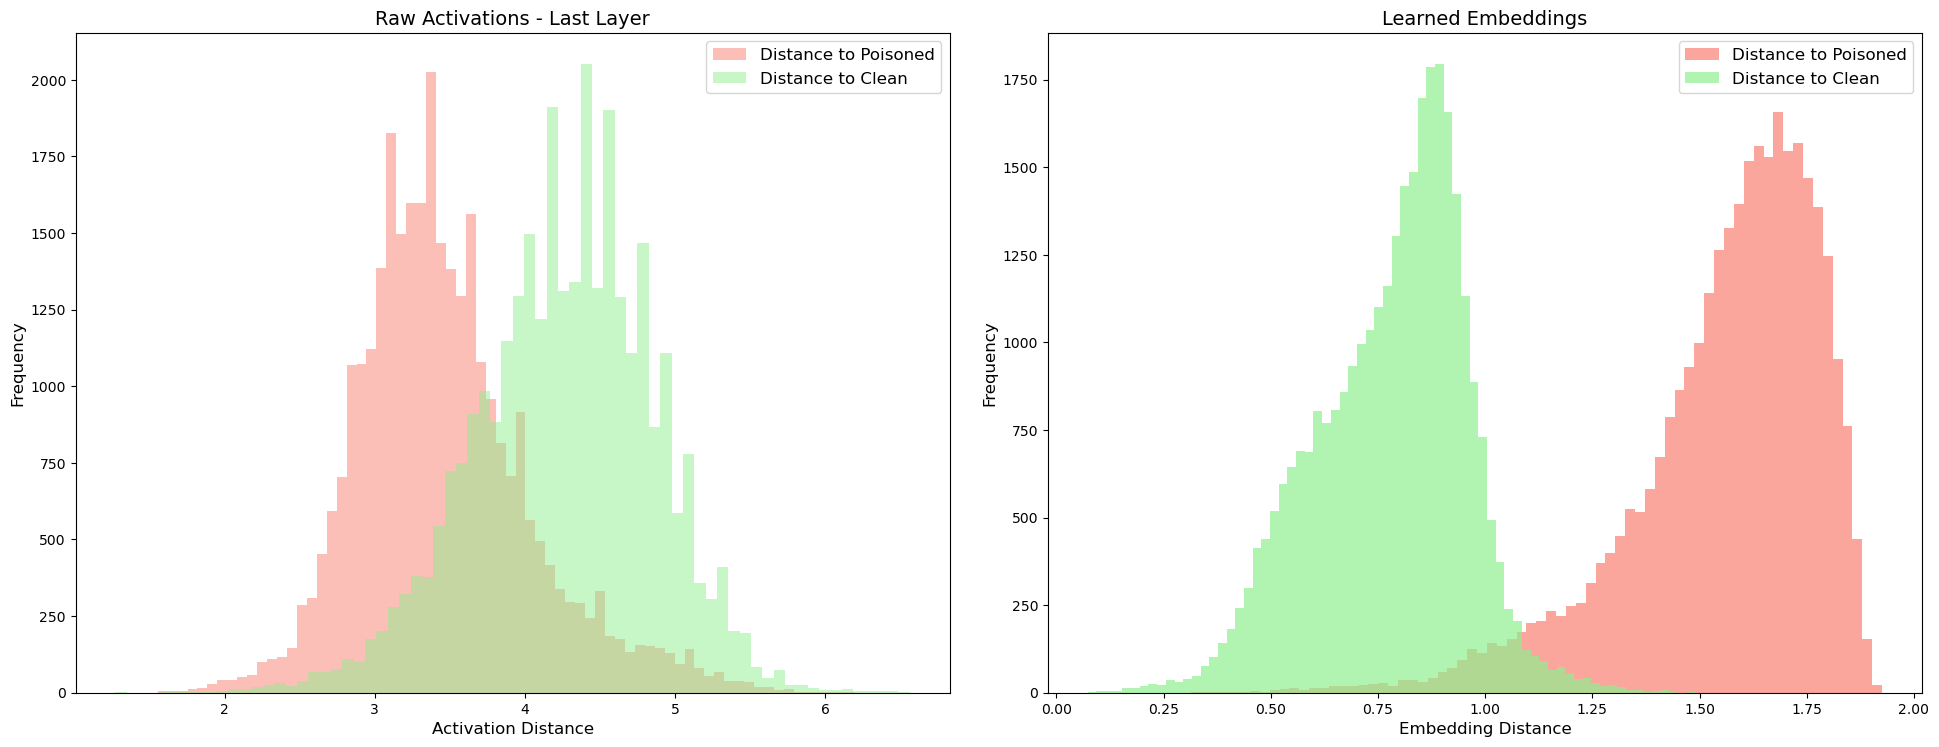

In [6]:
import matplotlib.pyplot as plt

n_bins = 70
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  
fig.tight_layout(pad=4.0)  

# Histogram for raw activations
axs[0].hist(all_distances_poisoned_raw, bins=n_bins, color='salmon', alpha=0.5, label='Distance to Poisoned')
axs[0].hist(all_distances_clean_raw, bins=n_bins, color='lightgreen', alpha=0.5, label='Distance to Clean')
axs[0].set_title('Raw Activations - Last Layer', fontsize=14)
axs[0].set_xlabel('Activation Distance', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].legend(fontsize=12)

# Histogram for learned embeddings
axs[1].hist(all_distances_poisoned, bins=n_bins, color='salmon', alpha=0.7, label='Distance to Poisoned')
axs[1].hist(all_distances_clean, bins=n_bins, color='lightgreen', alpha=0.7, label='Distance to Clean')
axs[1].set_title('Learned Embeddings', fontsize=14)
axs[1].set_xlabel('Embedding Distance', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].legend(fontsize=12)

plt.show()

In [7]:
from sklearn.metrics import roc_auc_score
max_dist = max(max(all_distances_poisoned),max(all_distances_clean))
all_distances_clean_subset = [(item/max_dist) for item in all_distances_clean]
all_distances_poisoned_subset = [(item/max_dist) for item in all_distances_poisoned]
all_distances = all_distances_clean_subset + all_distances_poisoned_subset
labels = [0 for i in range(0,len(all_distances_clean_subset))] + [1 for i in range(0,len(all_distances_poisoned_subset))]
roc_auc = roc_auc_score(labels,all_distances)
print(f'ROC AUC for learned embeddings: {roc_auc}')

max_dist_raw = max(max(all_distances_poisoned_raw),max(all_distances_clean_raw))
all_distances_clean_raw_subset = [(item/max_dist_raw) for item in all_distances_clean_raw]
all_distances_poisoned_raw_subset = [(item/max_dist_raw) for item in all_distances_poisoned_raw]
all_distances_raw = all_distances_clean_raw_subset + all_distances_poisoned_raw_subset
labels_raw = [0 for i in range(0,len(all_distances_clean_raw_subset))] + [1 for i in range(0,len(all_distances_poisoned_raw_subset))]
roc_auc_raw = roc_auc_score(labels_raw,all_distances_raw)
print(f'ROC AUC for raw activations: {roc_auc_raw}')

ROC AUC for learned embeddings: 0.9888394363804697
ROC AUC for raw activations: 0.1629991341117043
